In [1]:
# General import
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib.pyplot as plt
%matplotlib inline
# Local import
from Codes.dataprocess import DataGen
from Codes.dataprocess import Export_ep
from Codes.dataprocess import Add_noise
from Codes.algoviolet import violetBD
from Codes.display import Display_ker
from Codes.display import Display_im
from Codes.display import Display_epd
from Codes.myfunc import nablah
from Codes.myfunc import convolve
from Codes.simplex import Simplex

# Minimisation fonction bi-convexe concave

On introduit le probleme d'optimisation biconvex-concave
de déconvolution aveugle d'images 
avec l' a priori de noyau de convolution régulier,

$$
\underset{u \in U ,K \in \Sigma}{\text{min}} \; \underset{v}{\text{sup}} \;
\frac{1}{2} \| g - K * u\|^2 
+ \frac{1}{2} \alpha \| D K \|^2
+ \langle \nabla u , v \rangle
+ \chi_{B,\mu}(v)
\; .
$$

L'espace $\Sigma$ correspond à l'ensemble des simplexes 
(ensemble des noyaux à coefficient positif dont la somme des coefficients vaut 1).
Par extension on notera $\Sigma$ la fonction indicatrice de cet ensemble.
L'espace $U$ correspond à l'hypercube $[0,1]^{N_x \times N_y}$, ou la boule unité pour la norme $L^\infty$.
Sa fonction indicatrice correspond donc à $\chi_{B,1}$.

La fonction à minimiser peut alors se réécrire

$$
\underset{u ,K }{\text{min}} \; \underset{v}{\text{sup}} \;
\frac{1}{2} \| g - K * u\|^2 
+ \chi_{B,1} (u)
+ \frac{1}{2} \alpha \| D K \|^2
+ \Sigma(K)
+\langle \nabla u , v \rangle
+ \chi_{B,\mu}(v)
\; .
$$

On note

$$
L =\frac{1}{2} \| g - K * u\|^2 
+ \frac{1}{2} \alpha \| D K \|^2
+ \langle \nabla u , v \rangle
$$

Pour résoudre ce probleme d'optimisation on se propose de tester l'algorithme suivant,

$$
\left\{
\begin{align}
& \tilde{u}_{k+1} = \text{proj}_{B_1} \; (u_k - \tau \partial_u L(u_k,K_k,v_k) \; )\\
& K_{k+1} = \text{prox}_{\Sigma} \; (K_k - \gamma \partial_K L(\tilde{u}_{k+1},K_k,v_k) \; )\\
& v_{k+1}         = \text{prox}_{B_\mu} \; (v_k + \sigma \partial_v L (u_{k+1},K_{k+1},v_k) \; )\\
& u_{k+1} = \tilde{u}_{k+1} + \theta_u (\tilde{u}_{k+1} - u_k) \quad \text{(relaxation)}
\end{align}
\right.
$$

Question :
est-ce qu'on met une relaxation aussi sur $K$ ?

$$
K_{k+1} = \tilde{K}_{k+1} + \theta_K (\tilde{K}_{k+1} - K_k)  \quad \text{(relaxation aussi ?)}
$$

On écrit alors les dérivées partielles de $L$,

$$
\left\{
\begin{align}
& \partial_u L(u_k,K_k,v_k) \; ) = \text{div} \cdot v_k - \tilde{K} * (g-K*u)\\
& \partial_K L(\tilde{u}_{k+1},K_k,v_k) \; ) = - (g-K*u)*\tilde{u} + \alpha D^TDK \\
& \partial_v L (u_{k+1},K_{k+1},v_k) \; ) =  \nabla u
\end{align}
\right.
$$

On trace les énergies primales et duales au cours de la minimisation

$$
\left\{
\begin{align}
& Ep = \frac{1}{2} \| g - K * u\|^2 
+ \frac{1}{2} \alpha \| D K \|^2
+ \mu. \text{TV} (u) \\
\\
& Ed = - \langle \nabla u ,v \rangle - \chi_{B,\mu}(v)
\end{align}
\right.
$$

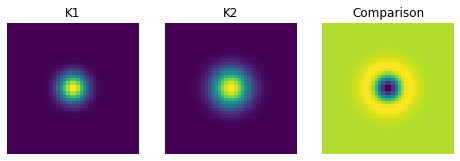

Erreur |K1 - K2|/ |K2| : 0.3500 


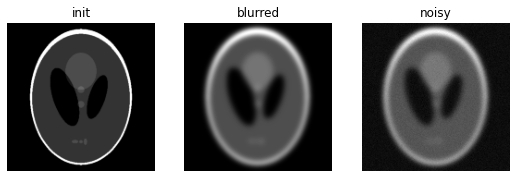

Erreur blurred |x_blurr- x_true|_2 :0.5093
Erreur |x_noisy - x_true|_2 :0.5105


In [2]:
K, K_shift, x_im, x_b, x_o1 = DataGen()

## Initialisation du noyau exacte - bruit std 0.05

Les erreurs initiales sont

$$
\begin{cases}
e_K = 0 \\
e_x = 0.2577
\end{cases}
$$

In [3]:
alpha = 100
mu    = 0.001
K_in   = K.copy()
x_in  = x_o1
K_out,x_out,Ep21,Ed21 = violetBD(K_in,x_in,x_b,alpha,mu,\
                            niter=10000,coeffK=0.01,\
                            proj_simplex=True)

iteration 200 %--- gradient K 693.5096 --- gradient x 0.6313
iteration 400 %--- gradient K 493.2040 --- gradient x 0.4344


KeyboardInterrupt: 

In [ ]:
Display_ker(K_out,K_in,mysize=(8,4))
Display_im(x_out,x_im,mysize=(6,3))
Display_epd(Ep21,Ed21)

In [ ]:
from Codes.simplex import Simplex
plt.plot(K_shift[20,:],label='shift')
plt.plot(K_out[20,:],label='out')
plt.plot(K[20,:],label='true')
plt.legend()

In [ ]:
Export_ep(Ep21,label='2',cas='1')

## Initialisation noyau proche - pas de bruit

In [9]:
alpha     = 100
mu        = 0.001
K_in      = K_shift.copy()
x_in      = x_b
K_out,x_out,Ep22,Ed22 = violetBD(K_in,x_in,x_b,alpha,mu,\
                            niter=3000,coeffK=10,\
                            proj_simplex=True)

iteration 60 %--- gradient K 1296.7926 --- gradient x 1.2460
iteration 120 %--- gradient K 833.5817 --- gradient x 0.7958
iteration 180 %--- gradient K 558.7468 --- gradient x 0.5536
iteration 240 %--- gradient K 396.0872 --- gradient x 0.4076
iteration 300 %--- gradient K 296.4036 --- gradient x 0.3162
iteration 360 %--- gradient K 232.8212 --- gradient x 0.2577
iteration 420 %--- gradient K 192.1413 --- gradient x 0.2179
iteration 480 %--- gradient K 165.7048 --- gradient x 0.1904
iteration 540 %--- gradient K 149.5259 --- gradient x 0.1716
iteration 600 %--- gradient K 141.1983 --- gradient x 0.1589
iteration 660 %--- gradient K 138.7713 --- gradient x 0.1519
iteration 720 %--- gradient K 140.2610 --- gradient x 0.1490
iteration 780 %--- gradient K 143.7090 --- gradient x 0.1486
iteration 840 %--- gradient K 148.8008 --- gradient x 0.1514
iteration 900 %--- gradient K 154.5255 --- gradient x 0.1540
iteration 960 %--- gradient K 160.7930 --- gradient x 0.1583
iteration 1020 %--- grad

In [10]:
Export_ep(Ep22,label='2',cas='2')

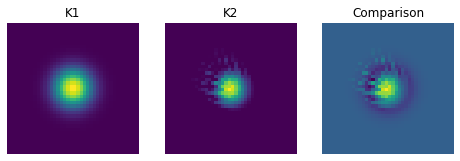

Erreur |K1 - K2|/ |K2| : 0.6093 


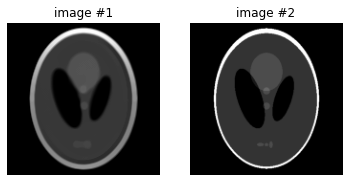

Erreur |im1 - im2|/|im2| :0.3616


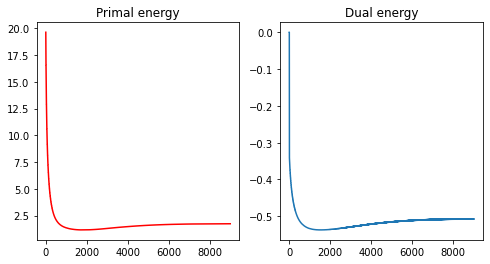

In [11]:
Display_ker(K_out,K_in,mysize=(8,4))
Display_im(x_out,x_im,mysize=(6,3))
Display_epd(Ep22,Ed22)

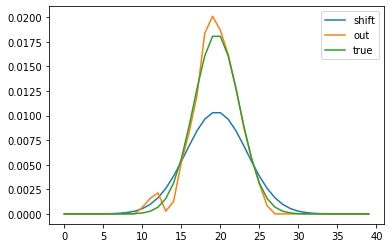

In [12]:
from Codes.simplex import Simplex
plt.plot(K_shift[20,:],label='shift')
plt.plot(K_out[20,:],label='out')
plt.plot(K[20,:],label='true')
plt.legend()

## Initialisation noyau proche - bruit std 0.05
Les erreurs initiales sont

$$
\begin{cases}
e_K=0.2811 \\
e_x=0.2724
\end{cases}
$$

In [ ]:
alpha     = 100
mu        = 0.001
K_in      = K_shift.copy()
x_in      = x_o1
K_out,x_out,Ep23,Ed23 = violetBD(K_in,x_in,x_o1,\
                            alpha,mu,\
                            niter=3000,\
                            proj_simplex=True)

In [ ]:
Export_ep(Ep23,label='2',cas='3')

In [ ]:
Display_ker(K_out,K_in,mysize=(8,4))
Display_im(x_out,x_im,mysize=(6,3))
Display_epd(Ep23,Ed23)

In [ ]:
from Codes.simplex import Simplex
plt.plot(K_shift[15,:],label='shift')
plt.plot(K_out[15,:],label='out')
plt.plot(K[15,:],label='true')
plt.legend()

### ANNEXES

In [ ]:
sys.exit()

In [ ]:
Nx,Ny = x_im.shape
# Kernel padding
K_pad = np.zeros(x_im.shape)
K_pad[Nx//2-M:Nx//2+M,Ny//2-M:Ny//2+M] = K
# Derivation padding
d      = -np.ones((3,3))
d[1,1] = 8
d_pad  = np.zeros((Nx,Ny))
d_pad[Nx//2-1:Nx//2+2,Ny//2-1:Ny//2+2] = d
# Parameters
alpha = 0
mu    = 0
gamma = 1
#
conv1 = convolve(K_pad,x_im)
conv2 = convolve(d_pad,K_pad)
ux,uy = nablah(x_im)
normu = np.abs(ux)+np.abs(uy)
#
Ep_b  = 0.5*gamma*np.linalg.norm(conv1-x_b)**2 \
          + 0.5*alpha*np.linalg.norm(conv2)**2\
          + mu/Nx/Ny*np.sum(normu)
Ep_o1  = 0.5*gamma*np.linalg.norm(conv1-x_o1)**2 \
          + 0.5*alpha*np.linalg.norm(conv2)**2\
          + mu/Nx/Ny*np.sum(normu)
print(" Min functionnal blurred : {:.6f},\
     \n Min functionnal noise   : {:.6f}".format(Ep_b,Ep_o1))